# Import packages

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
import tensorflow_addons as tfa
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

from utils import WindowGenerator
from plot_helper import plot_all, visualize_predictions, get_predictions

In [2]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Load and visualize data

In [3]:
x_columns = ["windspeed_x", "windspeed_y", "windspeed_z"]
x_columns += [f"vehicle_angular_velocity_xyz[{i}]" for i in range(3)]

In [4]:
y_columns = [f"ground_truth_velocity_xyz[{i}]" for i in range(3)]

In [5]:
data_dir = "datasets\\"
data1 = pd.read_csv(data_dir + "trajPose_interpo.csv")[x_columns + y_columns]
data2 = pd.read_csv(data_dir + "log_127_interpo.csv")[x_columns + y_columns]
data3 = pd.read_csv(data_dir + "log_213_interpo.csv")[x_columns + y_columns]
data4 = pd.read_csv(data_dir + "log_61_interpo.csv")[x_columns + y_columns]
data5 = pd.read_csv(data_dir + "log_62_interpo.csv")[x_columns + y_columns]

In [6]:
train_df = [data1, data2, data4]
valid_df = [data3]
test_df = [data5]

`Training data`

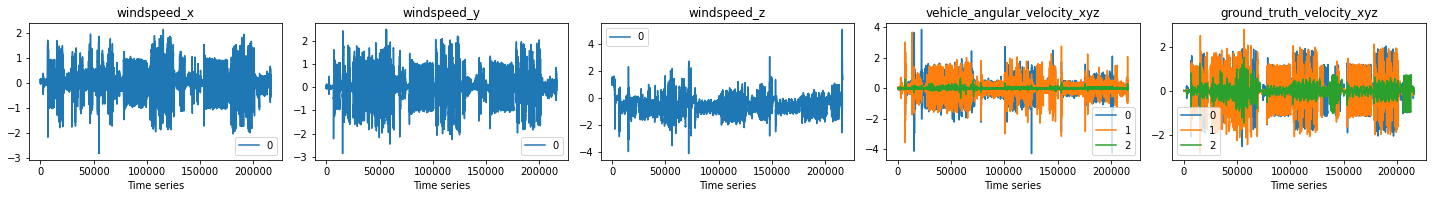

In [7]:
fig = plot_all(
    pd.concat(train_df, axis=0, ignore_index=True), cols=5, width=4, height=3
)

`Validation data`

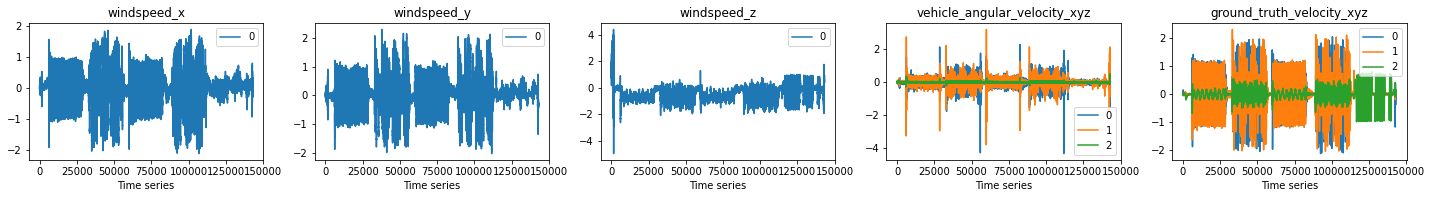

In [8]:
fig = plot_all(valid_df[0], cols=5, width=4, height=3)

`Test data`

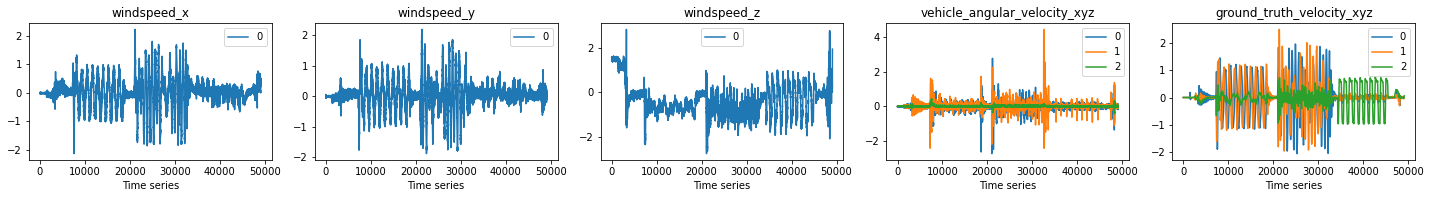

In [9]:
fig = plot_all(test_df[0], cols=5, width=4, height=3)

# Preprocess data

In [10]:
scaler = StandardScaler()
scaler = scaler.fit(pd.concat(train_df, axis=0, ignore_index=False)[x_columns])

In [11]:
scaled_train_df = []
for df in train_df:
    scaled_df = df.copy(deep=True)
    scaled_df[x_columns] = scaler.transform(scaled_df[x_columns])
    scaled_train_df.append(scaled_df)

In [12]:
scaled_valid_df = []
for df in valid_df:
    scaled_df = df.copy(deep=True)
    scaled_df[x_columns] = scaler.transform(scaled_df[x_columns])
    scaled_valid_df.append(scaled_df)

In [13]:
scaled_test_df = []
for df in test_df:
    scaled_df = df.copy(deep=True)
    scaled_df[x_columns] = scaler.transform(scaled_df[x_columns])
    scaled_test_df.append(scaled_df)

# Create windowed dataset

In [14]:
window_size = 500
batch_size = 512

window = WindowGenerator(
    scaled_train_df,
    scaled_valid_df,
    scaled_test_df,
    x_width=window_size,
    y_width=1,
    x_columns=x_columns,
    y_columns=y_columns,
    batch_size=batch_size,
    seed=1,
)

# GRU-based neural network

In [15]:
np.random.seed(1)
tf.random.set_seed(1)
keras.backend.clear_session()

net = keras.models.Sequential(
    [
        keras.layers.Input((None, len(x_columns))),
        keras.layers.Conv1D(16, 5, padding="same", activation="relu"),
        keras.layers.Conv1D(16, 5, padding="same", activation="relu"),
        keras.layers.GRU(16, return_sequences=True),
        keras.layers.GRU(16, return_sequences=False),
        keras.layers.Dense(3),
        keras.layers.Reshape((-1, 3)),
    ]
)

In [16]:
net.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          496       
                                                                 
 conv1d_1 (Conv1D)           (None, None, 16)          1296      
                                                                 
 gru (GRU)                   (None, None, 16)          1632      
                                                                 
 gru_1 (GRU)                 (None, 16)                1632      
                                                                 
 dense (Dense)               (None, 3)                 51        
                                                                 
 reshape (Reshape)           (None, 1, 3)              0         
                                                                 
Total params: 5,107
Trainable params: 5,107
Non-trainabl

## Training

In [17]:
def compile_and_fit(
    model,
    window,
    optimizer,
    loss="mse",
    metrics="mae",
    epochs=500,
    patience=20,
    restore_best_weights=True,
    verbose=None,
):
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=patience,
        mode="min",
        restore_best_weights=restore_best_weights,
    )
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    history = model.fit(
        window.train_set(),
        epochs=epochs,
        validation_data=window.val_set(shuffle=False, concat=True),
        callbacks=[early_stopping],
        verbose=verbose,
    )
    return history

In [18]:
steps_per_epoch = len(list(window.train_set().as_numpy_iterator()))

In [19]:
clr = tfa.optimizers.Triangular2CyclicalLearningRate(
    initial_learning_rate=1.0e-6,
    maximal_learning_rate=0.02,
    step_size=2 * steps_per_epoch,
)
optimizer = keras.optimizers.Adam(clr)

In [20]:
history = compile_and_fit(
    net,
    window,
    optimizer,
    loss="mse",
    metrics="mae",
    epochs=100,
    patience=12,
    restore_best_weights=True,
    verbose=1,
)

Epoch 1/100
420/420 [==============================] - 27s 51ms/step - loss: 0.0552 - mae: 0.1425 - val_loss: 0.0160 - val_mae: 0.0945
Epoch 2/100
420/420 [==============================] - 20s 48ms/step - loss: 0.0109 - mae: 0.0789 - val_loss: 0.0108 - val_mae: 0.0787
Epoch 3/100
420/420 [==============================] - 20s 48ms/step - loss: 0.0078 - mae: 0.0663 - val_loss: 0.0088 - val_mae: 0.0694
Epoch 4/100
420/420 [==============================] - 20s 48ms/step - loss: 0.0060 - mae: 0.0576 - val_loss: 0.0076 - val_mae: 0.0629
Epoch 5/100
420/420 [==============================] - 20s 48ms/step - loss: 0.0055 - mae: 0.0555 - val_loss: 0.0087 - val_mae: 0.0691
Epoch 6/100
420/420 [==============================] - 20s 48ms/step - loss: 0.0058 - mae: 0.0571 - val_loss: 0.0086 - val_mae: 0.0686
Epoch 7/100
420/420 [==============================] - 21s 49ms/step - loss: 0.0054 - mae: 0.0550 - val_loss: 0.0085 - val_mae: 0.0680
Epoch 8/100
420/420 [==============================] - 

In [21]:
plt.rcParams["font.size"] = "13"

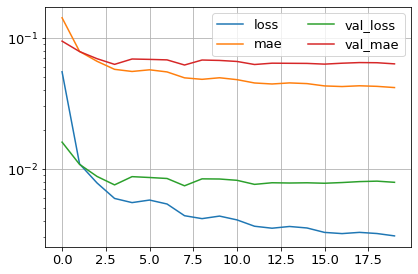

In [22]:
pd.DataFrame(history.history).plot(figsize=(6, 4), grid=True)
plt.yscale("log")
plt.legend(ncol=2)
plt.tight_layout()
plt.show()

## Evaluation

In [23]:
gru_val = net.evaluate(window.val_set(shuffle=False, concat=True), verbose=0)
gru_test = net.evaluate(window.test_set(shuffle=False, concat=True), verbose=0)
print(f"Performance of GRU on the validation set is {gru_val}")
print(f"Performance of GRU on the test set is {gru_test}")

Performance of GRU on the validation set is [0.007439574226737022, 0.06213247776031494]
Performance of GRU on the test set is [0.01118640135973692, 0.07122272253036499]


# Visualize the predictions

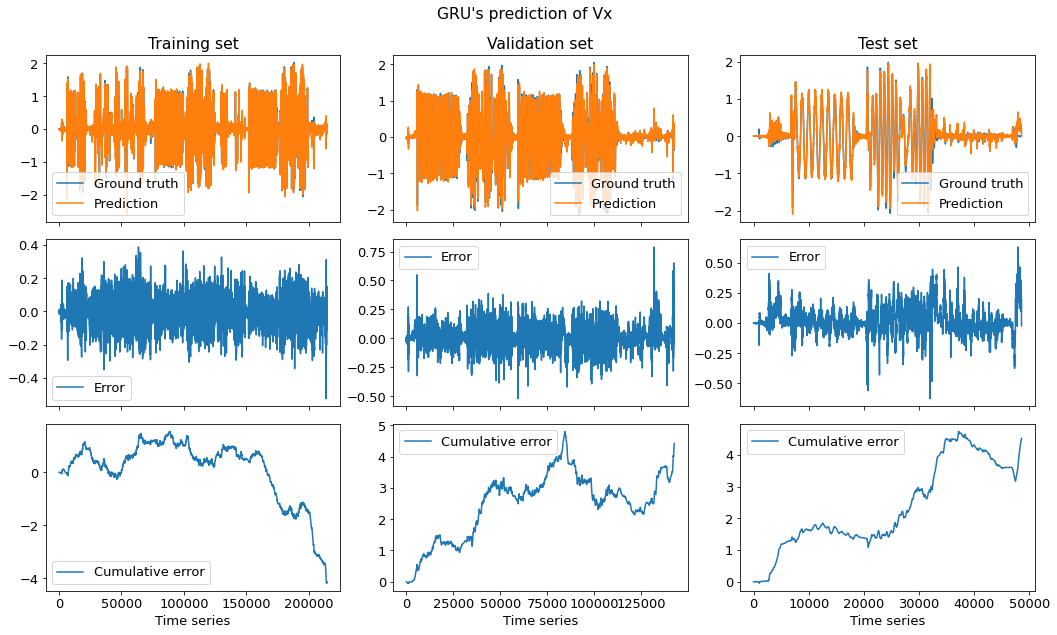

In [24]:
fig = visualize_predictions(
    window,
    plot_col=y_columns[0],
    model=net,
    title="GRU's prediction of Vx",
    height=3,
    width=5,
    residual=True,
    engine="matplotlib",
)

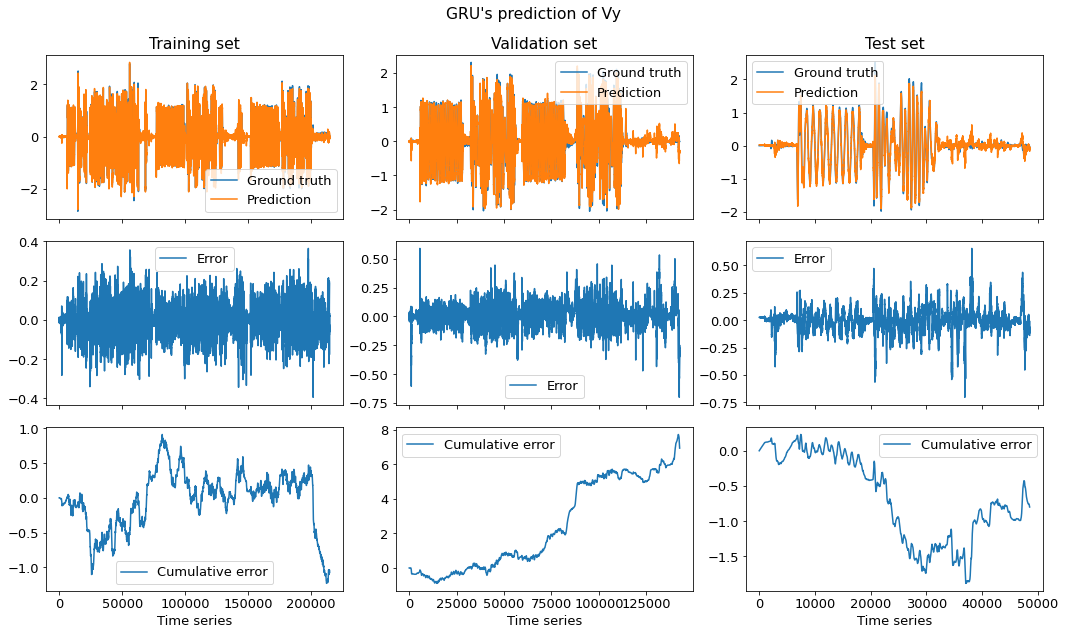

In [25]:
fig = visualize_predictions(
    window,
    plot_col=y_columns[1],
    model=net,
    title="GRU's prediction of Vy",
    height=3,
    width=5,
    residual=True,
    engine="matplotlib",
)

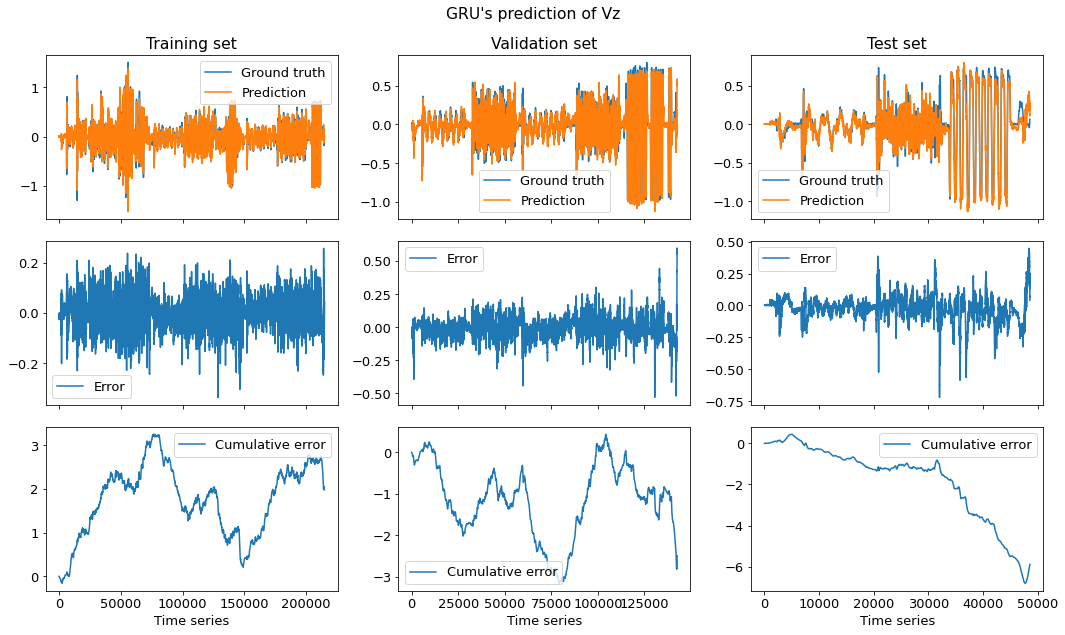

In [26]:
fig = visualize_predictions(
    window,
    plot_col=y_columns[2],
    model=net,
    title="GRU's prediction of Vz",
    height=3,
    width=5,
    residual=True,
    engine="matplotlib",
)

# Calculate the errors

In [27]:
true, pred = get_predictions(window, net)

In [28]:
timestamps = pd.read_csv(data_dir + "log_62_interpo.csv")["timestamp"]
timestamps = timestamps[window.total_window_size - 1 :]
timestamps = timestamps / 1.0e6

In [29]:
vx_col = "ground_truth_velocity_xyz[0]"
vy_col = "ground_truth_velocity_xyz[1]"
vz_col = "ground_truth_velocity_xyz[2]"

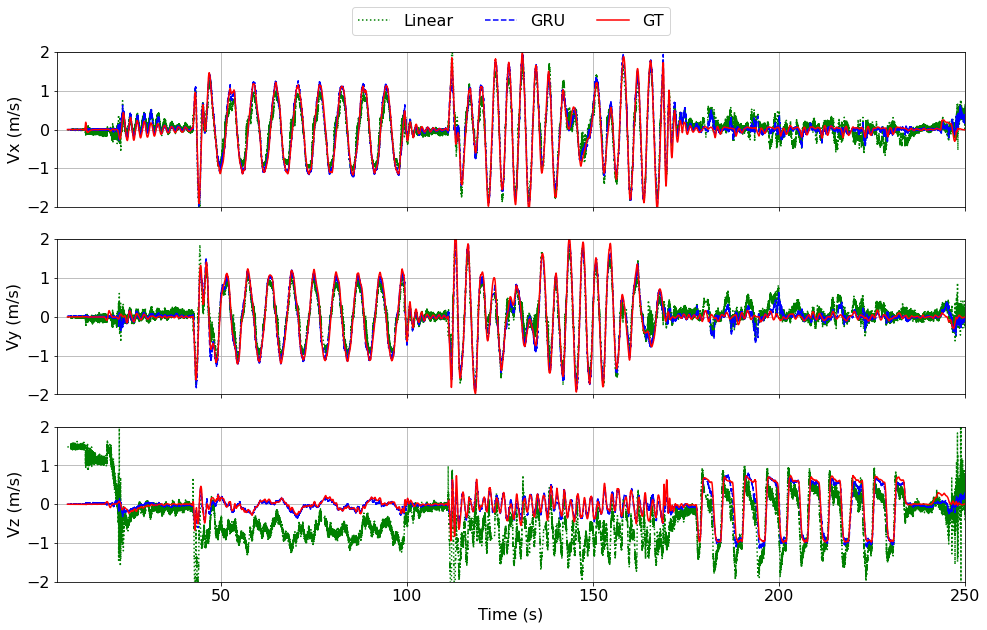

In [30]:
plt.rcParams["font.size"] = "16"
linewidth = 1
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(14, 9))
ax1.plot(timestamps, data5.loc[window.total_window_size - 1 :, "windspeed_x"], "g:")
ax1.plot(timestamps, pred[2][vx_col], "b--")
ax1.plot(timestamps, true[2][vx_col], "r")
ax1.set_ylabel("Vx (m/s)")
ax1.set_xlim([6, 250])
ax1.set_ylim([-2, 2])
ax1.legend(
    ["Linear", "GRU", "GT"],
    bbox_to_anchor=(0, 1.1, 1, 0.2),
    loc="center",
    mode=None,
    borderaxespad=0,
    ncol=3,
)
ax1.grid()

ax2.plot(timestamps, data5.loc[window.total_window_size - 1 :, "windspeed_y"], "g:")
ax2.plot(timestamps, pred[2][vy_col], "b--")
ax2.plot(timestamps, true[2][vy_col], "r")
ax2.set_ylabel("Vy (m/s)")
ax2.set_xlim([6, 250])
ax2.set_ylim([-2, 2])
ax2.grid()

ax3.plot(timestamps, data5.loc[window.total_window_size - 1 :, "windspeed_z"], "g:")
ax3.plot(timestamps, pred[2][vz_col], "b--")
ax3.plot(timestamps, true[2][vz_col], "r")
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Vz (m/s)")
ax3.set_xlim([6, 250])
ax3.set_ylim([-2, 2])
ax3.grid()
plt.tight_layout()
plt.savefig("figures//comparison.pdf")
plt.show()

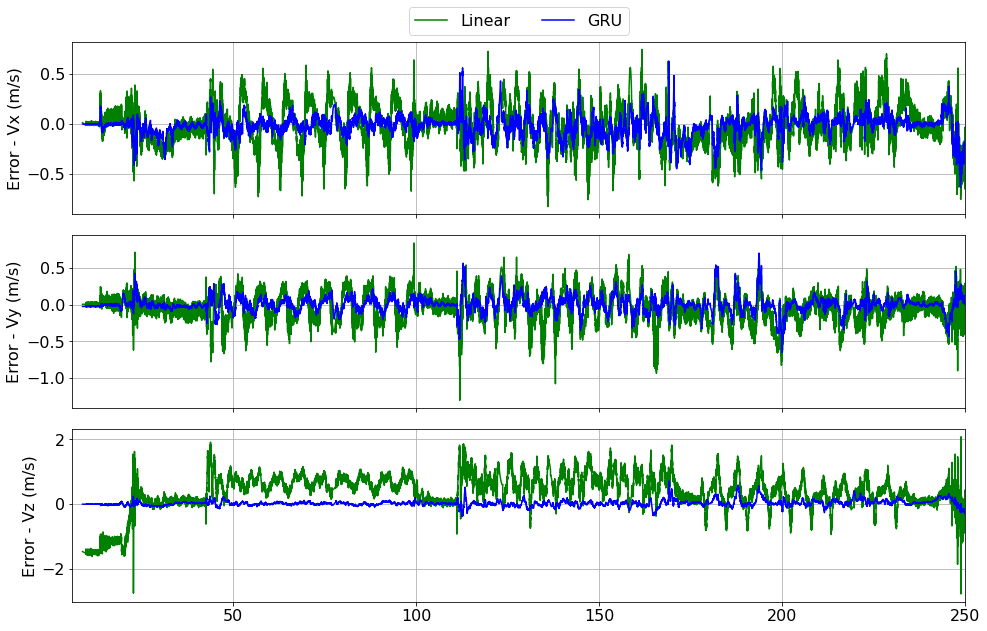

In [31]:
plt.rcParams["font.size"] = "16"
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(14, 9))
linear_ex = (
    true[2][vx_col].to_numpy()
    - data5.loc[window.total_window_size - 1 :, "windspeed_x"].to_numpy()
)
gru_ex = true[2][vx_col] - pred[2][vx_col]
ax1.plot(timestamps, linear_ex, "g")
ax1.plot(timestamps, gru_ex, "b")
ax1.set_ylabel("Error - Vx (m/s)")
ax1.set_xlim([6, 250])
ax1.legend(
    ["Linear", "GRU"],
    bbox_to_anchor=(0, 1.02, 1, 0.2),
    loc="center",
    mode=None,
    borderaxespad=0,
    ncol=3,
)
ax1.grid()

linear_ey = (
    true[2][vy_col].to_numpy()
    - data5.loc[window.total_window_size - 1 :, "windspeed_y"].to_numpy()
)
gru_ey = true[2][vy_col] - pred[2][vy_col]
ax2.plot(timestamps, linear_ey, "g")
ax2.plot(timestamps, gru_ey, "b")
ax2.set_ylabel("Error - Vy (m/s)")
ax2.set_xlim([6, 250])
ax2.grid()

linear_ez = (
    true[2][vz_col].to_numpy()
    - data5.loc[window.total_window_size - 1 :, "windspeed_z"].to_numpy()
)
gru_ez = true[2][vz_col] - pred[2][vz_col]
ax3.plot(timestamps, linear_ez, "g")
ax3.plot(timestamps, gru_ez, "b")
ax3.set_ylabel("Error - Vz (m/s)")
ax3.set_xlim([6, 250])
ax3.grid()
plt.tight_layout()
plt.savefig("figures//error.pdf")
plt.show()